In [1]:
import osmnx as ox
import geopandas as gpd
import numpy as npm
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from collections import deque
import datetime
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
CRS_PLOT = 'EPSG:4326'
DATA_DIR = '../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'
ROUTE = 'b26'

In [3]:
route_gdf = gpd.read_file(f'{EXPORTS_DIR}/{ROUTE}_stops.shp').iloc[1:]

In [4]:
bk = ox.io.load_graphml('bk.graphml')

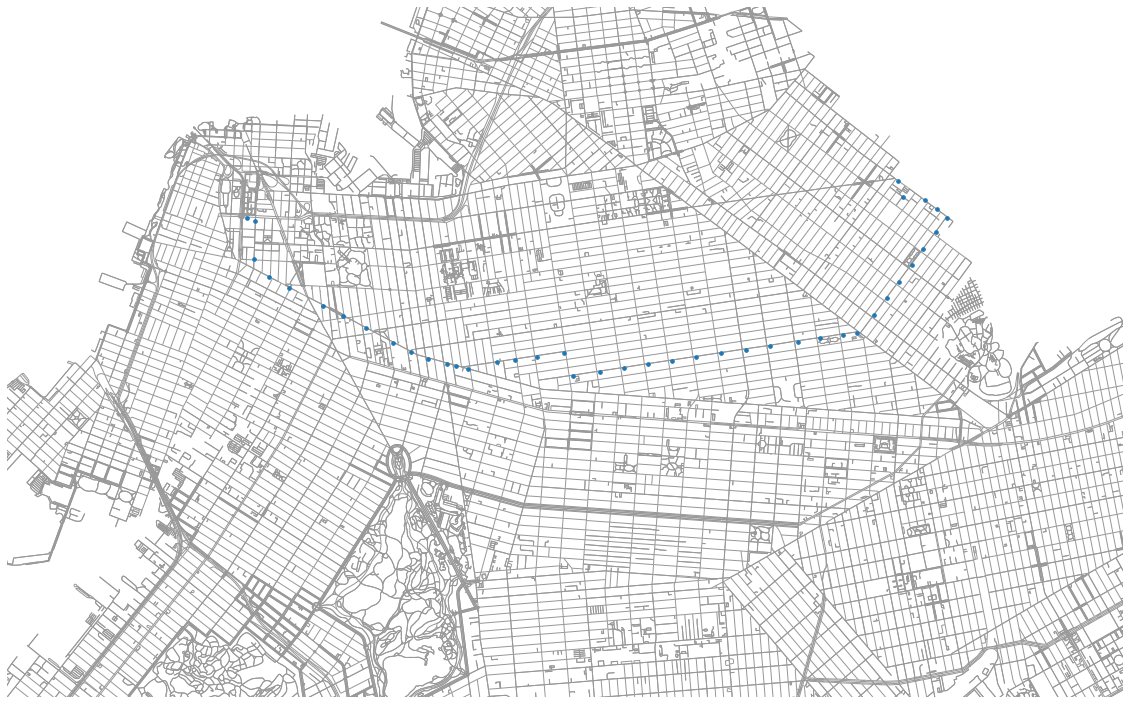

In [5]:
fig, ax = plt.subplots(figsize=(20, 20))
ox.plot_graph(bk, ax=ax, bgcolor=None, node_size=0, bbox=(40.71501, 40.65289, -73.88407, -74.01660), show=False, close=False)
route_gdf.plot(ax=ax, zorder=20, markersize=13)
plt.show()

In [6]:
ne = ox.nearest_edges(bk, route_gdf['stop_lon'], route_gdf['stop_lat'])

In [7]:
import itertools
nn = [[e[0], e[1]] for e in ne]
nn

[[4019305744, 42497737],
 [42481889, 42497737],
 [1693893347, 4735727610],
 [588036470, 42464832],
 [42464844, 2696777590],
 [42464855, 42464854],
 [5780018158, 5780018153],
 [42464866, 42464871],
 [42464923, 42464925],
 [42464930, 42464932],
 [42464934, 42464936],
 [42464938, 42464941],
 [42464945, 42464941],
 [42464948, 5533091530],
 [42489027, 6878525833],
 [42489038, 42489032],
 [42481586, 42489044],
 [42489044, 42481586],
 [5487734293, 5487734298],
 [42482385, 42506685],
 [42499209, 42506685],
 [42506695, 42499209],
 [42466977, 42506695],
 [42466977, 42473289],
 [42473289, 42499504],
 [42499504, 42485035],
 [42485035, 42493912],
 [42479161, 42493912],
 [42479161, 2693870420],
 [42505560, 42476382],
 [42476382, 42505560],
 [42499847, 42506743],
 [42486796, 42499847],
 [42486796, 42496779],
 [42506750, 42496779],
 [42506752, 42506750],
 [42506752, 597700359],
 [597700359, 42844974],
 [597700355, 597700358],
 [597700357, 597700354],
 [42489099, 42486701],
 [8421773046, 5482554802]]

In [8]:
def dedup_consecutive(a):
    b = []
    last = None
    for i in range(0, len(a)):
        c = a[i]
        if c != last:
            last = c
            b.append(c)
    return b

route_nodes = []
for i in range(0, len(nn) - 1):
    edge0 = nn[i]
    edge1 = nn[i + 1]
    sp = ox.shortest_path(bk, edge0[1], edge1[0])
    if sp is None:
        raise Exception('oof')
    nd = dedup_consecutive(edge0 + sp + [edge1[0]])
    route_nodes += nd

route_nodes = dedup_consecutive(route_nodes)


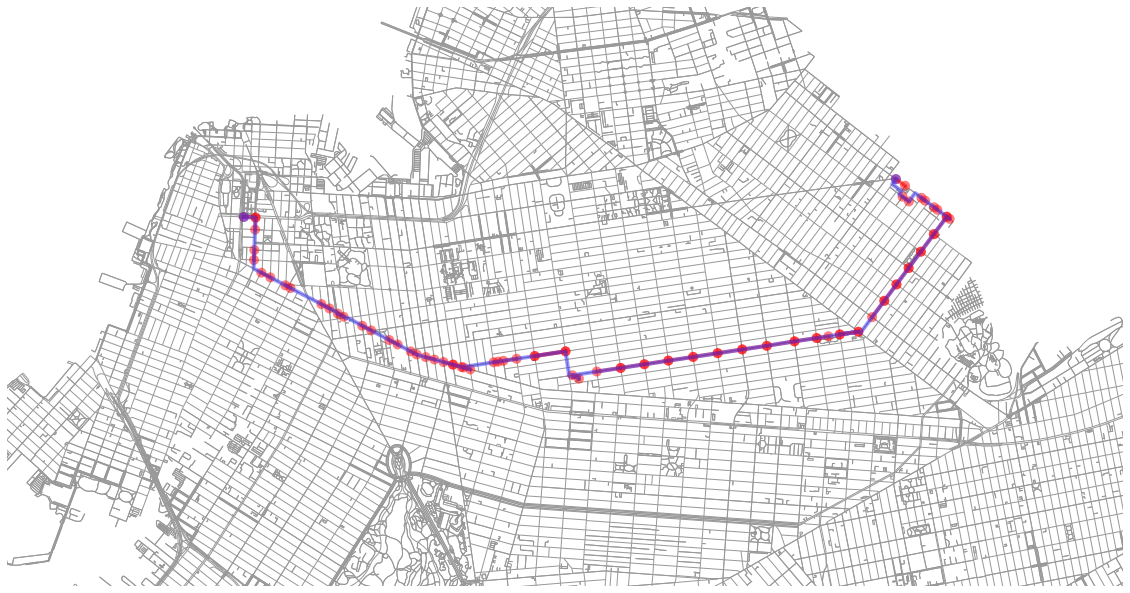

In [9]:
fig, ax = plt.subplots(figsize=(20, 20))
ox.plot_graph(bk, ax=ax, bgcolor=None, node_size=0, bbox=(40.71501, 40.66289, -73.88407, -74.01660), show=False, close=False)
ox.plot_graph_routes(bk, nn, ax=ax, show=False, close=False)
ox.plot_graph_route(bk, route_nodes, ax=ax, show=False, close=False, route_color='#3333ff')
plt.show()

In [10]:
import networkx as nx

In [11]:
graph = nx.MultiDiGraph()

In [12]:
def create_route_subgraph(node_ids):
    graph = nx.MultiDiGraph()
    for node_id in node_ids:
        node = bk.nodes[node_id]
        graph.add_node(node_id, **node)
    for i in range(0, len(node_ids) - 1):
        graph.add_edge(node_ids[i], node_ids[i + 1])
    graph.graph['crs'] = CRS_PLOT
    return graph
route_graph = create_route_subgraph(route_nodes)
ox.io.save_graphml(route_graph, f'{ROUTE}.graphml')